# Analysis

## Import & Load Data from Step 3

In [1]:
import json
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter

from automix import POMDP, Threshold, SelfConsistency, Automix


def load_data():
    llama2_outputs = pd.read_json("../data/automix_release_with_decision.jsonl", lines=True, orient="records")
    train_outputs = llama2_outputs[llama2_outputs['split'] == 'train']
    test_outputs  = llama2_outputs[llama2_outputs['split'] == 'val']

    train_outputs = train_outputs[train_outputs['dataset'] == 'cnli']
    test_outputs  = test_outputs[test_outputs['dataset'] == 'cnli']

    return train_outputs, test_outputs

train_outputs, test_outputs = load_data()

## 1. What is Verifier doing?

In [45]:
train_outputs['f1_delta'] = train_outputs['llama70b_f1'] - train_outputs['llama13b_f1']
test_outputs['f1_delta'] = test_outputs['llama70b_f1'] - test_outputs['llama13b_f1']

train_outputs['p_ver_13b_n32'] = train_outputs['p_ver_13b_n32'].apply(lambda x: int(x*32)/32) # Discretize for visualization
train_curve = [train_outputs[train_outputs['p_ver_13b_n32'] == i/32]['f1_delta'].mean() if i/32 in train_outputs['p_ver_13b_n32'].values else 0 for i in range(33) ]
train_curve = gaussian_filter(train_curve, sigma=1)

test_outputs['p_ver_13b_n32'] = test_outputs['p_ver_13b_n32'].apply(lambda x: int(x*32)/32) # Discretize for visualization
test_curve = [test_outputs[test_outputs['p_ver_13b_n32'] == i/32]['f1_delta'].mean() if i/32 in test_outputs['p_ver_13b_n32'].values else 0 for i in range(33) ]
test_curve = gaussian_filter(test_curve, sigma=1)

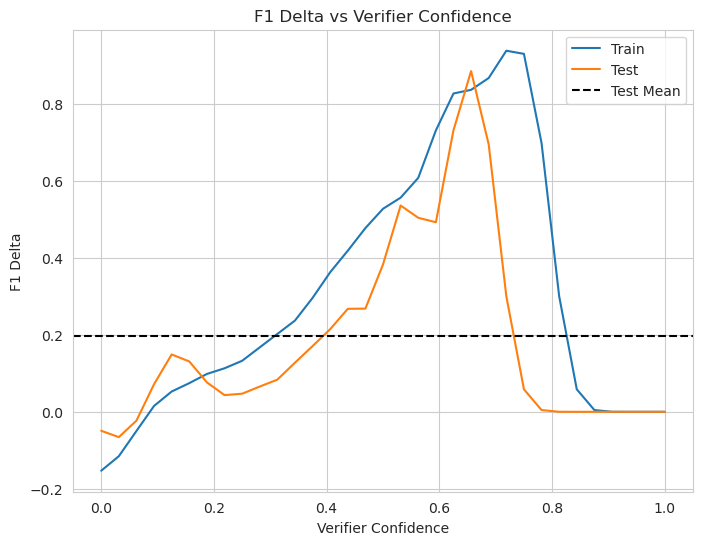

In [51]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the train_curve
ax.plot([i/32 for i in range(33)], train_curve, label='Train')

# Plot the test_curve
ax.plot([i/32 for i in range(33)], test_curve, label='Test')

# Plot the mean f1_delta
ax.axhline(y=test_outputs['f1_delta'].mean(), color='black', linestyle='--', label='Test Mean')

# Plot labels, title, etc
ax.set_xlabel('Verifier Confidence')
ax.set_ylabel('F1 Delta')

ax.set_title('F1 Delta vs Verifier Confidence')
ax.legend()

### Discussion

- Simply Thresholding will failed right. But Why? 
- Because it sent the low confidence points to SLM.
- That would be intutive, since if verifier is confused, then LLM is likely to solve it.
- But, that would be true for well-calibrated verifiers.
- Real-World few-shot verifiers will rarely be calibrated.
- So what about meta-verifier? Meta-verifier identifies routing window from train:
    0.5 to 0.9 and routes them to llm
- Result Simple Verifier: -3% ; Meta-Verifier: 89%

## Are Verification Probs meaningful?

In [52]:
train_outputs, test_outputs = load_data()

In [57]:
def corrcoef(x, y): return np.abs(np.corrcoef(x, y)[0, 1])

test_outputs['f1_delta'] = test_outputs['llama70b_f1'] - test_outputs['llama13b_f1']

# Compute the correlation coefficients
corrcoef_ver_f1_delta = corrcoef(test_outputs['p_ver_13b_n32'], test_outputs['f1_delta'])
corrcoef_ver_llama13b = corrcoef(test_outputs['p_ver_13b_n32'], test_outputs['llama13b_f1'])
corrcoef_ver_llama70b = corrcoef(test_outputs['p_ver_13b_n32'], test_outputs['llama70b_f1'])

# Create a table
table = pd.DataFrame({'Correlation Coefficient': [corrcoef_ver_llama13b, corrcoef_ver_f1_delta, corrcoef_ver_llama70b],
                      'Metric': ['Llama13b F1', 'F1 Delta', 'Llama70b F1']})
table = table.set_index('Metric')
table = table.round(3)
# table = table.to_latex()
print(table)

             Correlation Coefficient
Metric                              
Llama13b F1                   -0.065
F1 Delta                       0.155
Llama70b F1                    0.196


### Discussion

- Correlation signal between Verifier signal from LLaMA-13b is only slightly positive.
- However, verifier provides more rich signal about LLM than SLM, despite running on SLM outputs.
- Why? Because verifier tells us about the difficulty of question as well, instead of just the correctness of answer.
- Ex: A confused verifier implies that the question is very tough, and perhaps even LLM cannot solve it: Unsolvable Question.  

## How good is an Oracle Meta-Verifier?

In [59]:
train_outputs, test_outputs = load_data()

In [64]:
mixer = Automix(POMDP(num_bins=8))
mixer.train(test_outputs)
print('Oracle:', mixer.evaluate(test_outputs, return_dict=True)['ibc_lift'])
mixer.train(train_outputs)
print('POMDP :', mixer.evaluate(test_outputs, return_dict=True)['ibc_lift'])

Error in categorization division by zero
Oracle: 1.1462870612600846
POMDP : 0.8821269827435964


In [ ]:
Oracle: 1.1462870612600846
POMDP : 0.8821269827435964

### Discussion
- Oracle can provide an ibc lift of upto 115% on the test set compared to POMDP.
- While significant shift, this shows that "given the input signal" meta-verifier takes, after a stage it becomes more important to improve the verifier itself.  

## How many verifier samples are good enough?

In [ ]:
train_outputs, test_outputs = load_data()

In [2]:
def compute_fraction_correct(lst):
    total_valid = sum([1 for item in lst if "the ai generated answer is" in item.lower()])
    if total_valid == 0:
        return 0
    correct_count = sum([1 for item in lst if "the ai generated answer is correct" in item.lower()])
    return correct_count / total_valid

In [3]:
sample_wise_lifts = dict()
for num_samples in [4,8, 12, 16, 24, 32]:
    train_outputs[f'p_ver_13b_n{num_samples}'] = train_outputs['llama13b_ver_n32'].apply(lambda x: compute_fraction_correct(x[:num_samples]))
    test_outputs[f'p_ver_13b_n{num_samples}'] = test_outputs['llama13b_ver_n32'].apply(lambda x: compute_fraction_correct(x[:num_samples]))

    mixer = Automix(POMDP(num_bins=num_samples), verifier_column=f'p_ver_13b_n{num_samples}')
    mixer.train(train_outputs)
    sample_wise_lifts[num_samples] = mixer.evaluate(test_outputs, return_dict=True)['ibc_lift']
    print(f'POMDP {num_samples}:', sample_wise_lifts[num_samples])

POMDP 4: 0.6939473543844682
POMDP 8: 0.8306505072630858
POMDP 12: 1.6243098159509195
POMDP 16: 1.5262696955790136
POMDP 24: 1.6777508431703225
POMDP 32: 1.3931888327721664


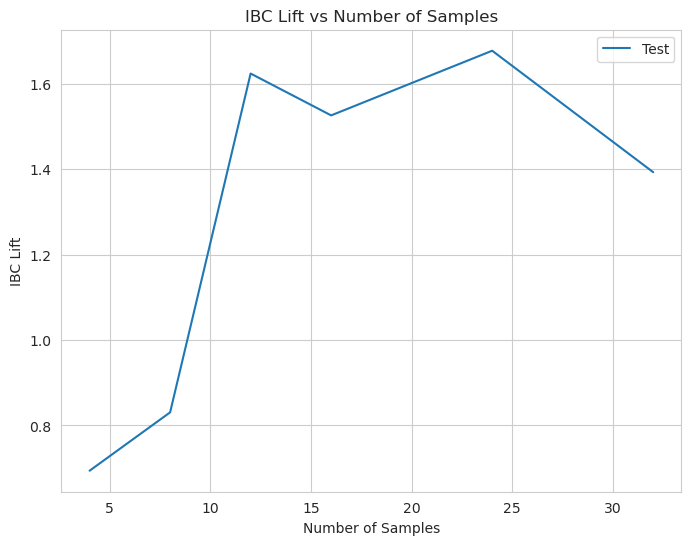

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the train_curve
ax.plot([i for i in sample_wise_lifts.keys()], [sample_wise_lifts[i] for i in sample_wise_lifts.keys()], label='Test')

# Plot labels, title, etc
ax.set_xlabel('Number of Verifier Samples')
ax.set_ylabel('IBC Lift')

ax.set_title('IBC Lift vs Number of Samples')
ax.legend()

### Discussion
- The graph shows that while 4-8 verifier samples may not be clearly enough, performance saturates at around 12-16 samples, since they are enough to estimate the verifier's confidence.
- However, exact value will be dataset dependent.